# Tutorial

This tutorial will guide through the creation and analysis of a superconducting circuit with CircuitQ. It shows some of the core functionalities of CircuitQ and demonstrates how to use them. While the variety of possible input circuits is high, we will here focus on the Fluxonium as an example. 


## Import statements

First, import `circuitq` and `networkx`. The latter toolbox is required to construct the circuit graph.


In [1]:
import circuitq as cq
import networkx as nx

It is also convenient to import `numpy` for the use of numerical expressions and `pyplot` to visualize some results.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Create circuit graph

A superconducting circuit can be related to a graph by relating all circuit elements between two nodes to an edge of the graph. Possible elements are capacitances (`'C'`), linear inductances (`'L'`) and Josephson junctions (`'J'`).

Since multiple edges of such a graph can be in parallel we work with the `MultiGraph` class of `networkx`.

Let's consider the Fluxonium as an example, which consists of a linear inductance and a Josephson junction in parallel together with a shunted capacity.

<img src="circuit_figures/fluxonium_circuit.png" alt="Fluxonium Circuit" width="200"/>

To initialize the circuit, we execute the following:

In [3]:
graph = nx.MultiGraph()
graph.add_edge(0,1, element = 'C')
graph.add_edge(0,1, element = 'J')
graph.add_edge(0,1, element = 'L')

circuit = cq.CircuitQ(graph)

Here, we created a graph with three elements in between node 0 and node 1. The `CircuitQ` class is the core of the toolbox. An element of this class corresponds to a superconducting circuit. Ground nodes and charge offset nodes can be specified upon initialization. Please refer to the API reference for more details.

CircuitQ's function `visualize_circuit_general()` can be used to visualize the graph.

## Symbolic Hamiltonian

CircuitQ performs an automated quantization of the input circuit. It provides a symbolic `SymPy` expression for the corresponding circuit Hamiltonian.

In [4]:
circuit.h

-E_{J010}*cos(3.03853489761902e+15*\Phi_{1}) + (\Phi_{1} + \tilde{\Phi}_{010})**2/(2*L_{010}) + 0.5*q_{1}**2/C_{01}

## Parameters

Besides the flux and charge variables $\phi$ and $q$, the Hamiltonian contains system parameters, whose values can be changed to tune the circuit.

In [5]:
circuit.h_parameters

[C_{01}, E_{J010}, L_{010}, \tilde{\Phi}_{010}]

In this case it contains the capacity $C_{01}$, the Josephson energy $E_{J010}$ and the inductance $L_{010}$. During quantization, CircuitQ automatically detects inductive loops and assigns loop fluxes to them, which is represented by $\tilde{\Phi}_{010}$. If a charge offset would have been assigned upon initialization, it would also appear as a parameter $qo$.

Let's assign a numerical value for the Josephson energy and the external flux

In [6]:
EJ = circuit.c_v["E"]/3
phi_ext = np.pi*circuit.phi_0 

`circuit.c_v` is a dictionary for characteristic parameter values. `circuit.phi_0` is the flux quantum, which we define as $\frac{\hbar}{2e}$. 

## Numerical Hamiltonian
To analyze the circuit's quantum physical properties, a numerical representation of the Hamiltonian has to be generated.

In [7]:
h_num = circuit.get_numerical_hamiltonian(401, 
                    parameter_values=[False, EJ, False, phi_ext ])

The method `get_numerical_hamiltonian()` takes the length of the matrices representing the flux and charge variables as the first parameter input (here `401`). CircuitQ automatically performs the numerical implementation of the node variables either in the charge basis, in the flux basis or also in a combination of both - depending on the periodicity of the potential along the individual flux variables. In the exemplary case of the Fluxonium, the flux basis will be used due to the harmonic contribution of the linear inductance. The length of the numerical flux coordinate grid can be set manually by using the keyword `grid_length`. This may have a crucial impact on the numerical results. If it is not specified (like in the example above) it is set to the default value $\Phi_{max} = 4 \pi \Phi_0$. For the cases which are implemented in the charge basis, `CircuitQ`'s method `transform_charge_to_flux()` can be used to be able to express the eigenstates still in the flux basis (see More Examples -> Flux Qubit).

To assign specific parameter values, use an input list for `paramter_values`, with the same order as the `h_parameters` list. If a value is set to `False`, a characteristic default value will be assigned to it.

The numerical Hamiltonian is represented as a sparse `csr_matrix` from the `SciPy` package.

## Diagonalization

To get the (lowest) eigenvalues and eigenstates of the numerical Hamiltonian, use `get_eigensystem()` which is a wrapper around `SciPy`'s `eigsh` function for sparse matrices.

In [8]:
eigv, eigs = circuit.get_eigensystem()

Finally, we can plot the lowest eigenstates of the circuit.

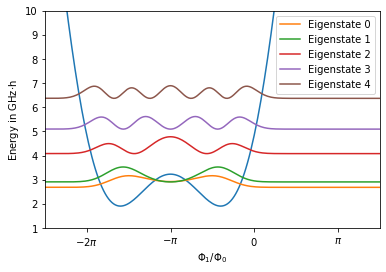

In [9]:
h = 6.62607015e-34 
y_scaling = 1/(h *1e9)
plt.plot(circuit.flux_list, np.array(circuit.potential)*y_scaling, lw=1.5)
for n in range(5):
    plt.plot(circuit.flux_list, 
             (eigv[n]+ abs(eigs[:,n])**2*2e-23)*y_scaling
             ,label="Eigenstate " +str(n))
plt.legend()
plt.xlabel(r"$\Phi_1 / \Phi_0$")
plt.ylabel(r"Energy in GHz$\cdot$h")
plt.xticks(np.linspace(-2*np.pi, 1*np.pi, 4)*circuit.phi_0 ,
           [r'$-2\pi$', r'$-\pi$',r'$0$',r'$\pi$'])
plt.xlim(-2.5*np.pi*circuit.phi_0, 1.5*np.pi*circuit.phi_0)
plt.ylim(1,10)
plt.show()

To plot the potential, the `potential` attribute of a `CircuitQ` instance can be used if the problem is 1-dimensional and formulated in flux basis.


## Anharmonicity

To operate the circuit as a qubit, a certain degree of the spectrum's anharmonicity is desired. CircuitQ provides a measure for this purpose, which can be given by `get_spectrum_anharmonicity()`. The method considers the transition that is the closest to the qubit transition and subsequently calculates the quotient between these two transitions and returns abs(1-quotient). A cutoff has been implemented, such that the returned anharmonicity is within $[0,1]$.

In [10]:
circuit.get_spectrum_anharmonicity()

1

## $T1$ time
The robustness against decoherence is a crucial property of a circuit. For this purpose, we developed three measures to evaluate the $T1$ time contribution due to quasiparticle tunneling,

In [11]:
T1_qp = circuit.get_T1_quasiparticles()
print("Quasiparticles noise contribution T1 = {:e} s".format(T1_qp))

Quasiparticles noise contribution T1 = 2.272398e-05 s


charge noise,

In [12]:
T1_c = circuit.get_T1_charge()
print("Charge noise contribution T1 = {:e} s".format(T1_c))

Charge noise contribution T1 = 1.891442e-04 s


and flux noise

In [13]:
T1_f = circuit.get_T1_flux()
print("Flux noise contribution T1 = {:e} s".format(T1_f))

Flux noise contribution T1 = 1.895929e-02 s


This leads to an overall $T1$ time measure of:

In [14]:
print("Total T1 = {:e} s".format( 1/( 1/T1_qp + 1/T1_c + 1/T1_f)))

Total T1 = 2.026503e-05 s


Please refer to our preprint for more details on how the noise contributions are calculated.

## Parameter sweep

The dependence of circuit properties on the value of one or more parameters is a crucial aspect to consider when analysing superconducting circuits. 

The exemplary spectrum above depends on the value of the external flux $\tilde{\Phi}_{010}$. For the previous plot, we have chosen the external flux to be $\pi \cdot \Phi_0$. If we set this value to $0$, the spectrum has the following form:

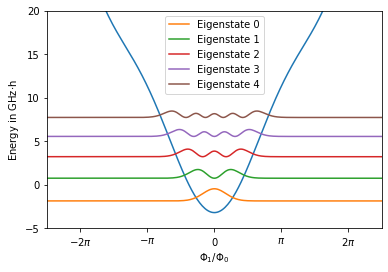

In [15]:
phi_ext = 0

circuit.get_numerical_hamiltonian(401, parameter_values=[False, EJ, False, phi_ext ])
eigv, eigs = circuit.get_eigensystem()

plt.plot(circuit.flux_list, np.array(circuit.potential)*y_scaling, lw=1.5)
for n in range(5):
    plt.plot(circuit.flux_list, 
             (eigv[n]+ abs(eigs[:,n])**2*2e-23)*y_scaling 
             ,label="Eigenstate " +str(n))
plt.legend()
plt.xlabel(r"$\Phi_1 / \Phi_0$")
plt.ylabel(r"Energy in GHz$\cdot$h")
plt.xticks(np.linspace(-2*np.pi, 2*np.pi, 5)*circuit.phi_0 ,
           [r'$-2\pi$', r'$-\pi$',r'$0$',r'$\pi$',r'$2\pi$'])
plt.xlim(-2.5*np.pi*circuit.phi_0, 2.5*np.pi*circuit.phi_0)
plt.ylim(-5,20)
plt.show()

The harmonicity of the spectrum increased due to the change of the external flux. This fact will also be reflected when calculating the anahrmonicity.

In [16]:
circuit.get_spectrum_anharmonicity()

0.05288147513284358

We can further study the dependence of the lowest eigenenergies as a function of the external flux.

Let's start by calculating the eigenvalues for differnt values of the external flux. Note that the order of the `paramter_values` list stays the same.

In [17]:
eigenvalues = []
phi_ext_list = np.linspace(-2*np.pi*circuit.phi_0,2*np.pi*circuit.phi_0,100)
for phi_ext in phi_ext_list:
    circuit.get_numerical_hamiltonian(401, parameter_values=[False, EJ, False, phi_ext])
    eigv, eigs = circuit.get_eigensystem(5)
    eigenvalues.append(eigv)

Finally, we can plot the parameter sweep.

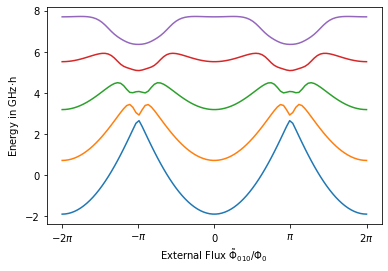

In [18]:
plt.plot(phi_ext_list, np.array(eigenvalues)*y_scaling)
plt.xlabel(r"External Flux $ \tilde{\Phi}_{010} / \Phi_0$")
plt.ylabel(r"Energy in GHz$\cdot$h")
plt.xticks(np.linspace(-2*np.pi, 2*np.pi, 5)*circuit.phi_0 ,
           [r'$-2\pi$', r'$-\pi$',r'$0$',r'$\pi$',r'$2\pi$'])
plt.show()

We are not restricted in analyzing only the impact of the external flux, as this variation can be done for any parameter in `paramter_values`.

## Charge offset

The offset of a node charge can be tuned by an external source. To work with charge offsets, the corresponding nodes have to be specified when initializing a `CircuitQ` instance. As a demonstration let's choose node 1 to have a charge offset.

In [19]:
circuit = cq.CircuitQ(graph, offset_nodes=[1])
circuit.h

-E_{J010}*cos(3.03853489761902e+15*\Phi_{1}) + (\Phi_{1} + \tilde{\Phi}_{010})**2/(2*L_{010}) + 0.5*(q_{1} + qo_{1})**2/C_{01}

The node charge $q_1$ is now shifted by an offset charge $qo_1$. This new variable now also appears in in the parameter list:

In [20]:
circuit.h_parameters

[C_{01}, E_{J010}, L_{010}, \tilde{\Phi}_{010}, qo_{1}]

Finally, we can also study the impact of the external charge on the spectrum of the exemplary circuit.

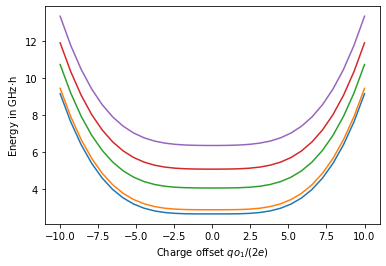

In [21]:
eigenvalues = []
phi_ext = np.pi*circuit.phi_0
q_off_list = np.linspace(-10*2*circuit.e,10*2*circuit.e,30)
for q_off in q_off_list:
    circuit.get_numerical_hamiltonian(401, parameter_values=[False, EJ, False, phi_ext, q_off])
    eigv, eigs = circuit.get_eigensystem(5)
    eigenvalues.append(eigv)
    
plt.plot(q_off_list/(2*circuit.e), np.array(eigenvalues)*y_scaling)
plt.xlabel(r"Charge offset $ qo_1 / (2e)$")
plt.ylabel(r"Energy in GHz$\cdot$h")
plt.show()